# Mean-Variance Optimization
In this notebook, I explore mean-variance optimization to construct optimally risky portfolios using the S&P 500 for the universe of stocks. Part one creates four portfolios, combining long/short and non-leverage/leverage. The end of part one concludes with plotting the efficient frontier and capital allocation line for the portfolio with the highest Sharpe ratio. Part two of the notebook backtests the non-leveraged portfolios with different lookback and rebalancing periods against the target market index. The notebook concludes with a summary of key findings.

In [337]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

from scipy.optimize import minimize

# Settings
plt.style.use('ggplot')

In [338]:
# Download and clean the data
risk_free = 0.043   # US 1M Rate (approximate for time notebook was created)
borrow_rate = 0.065 # Margin rate for borrowing

tickers = pd.read_csv('data/sp500_companies.csv')['Symbol'].to_list()

data = yf.download(tickers, period='5y', interval='1d', auto_adjust=True)['Close']
data.dropna(axis=1, inplace=True)

[*********************100%***********************]  502 of 502 completed

1 Failed download:
['DFS']: YFPricesMissingError('possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")')


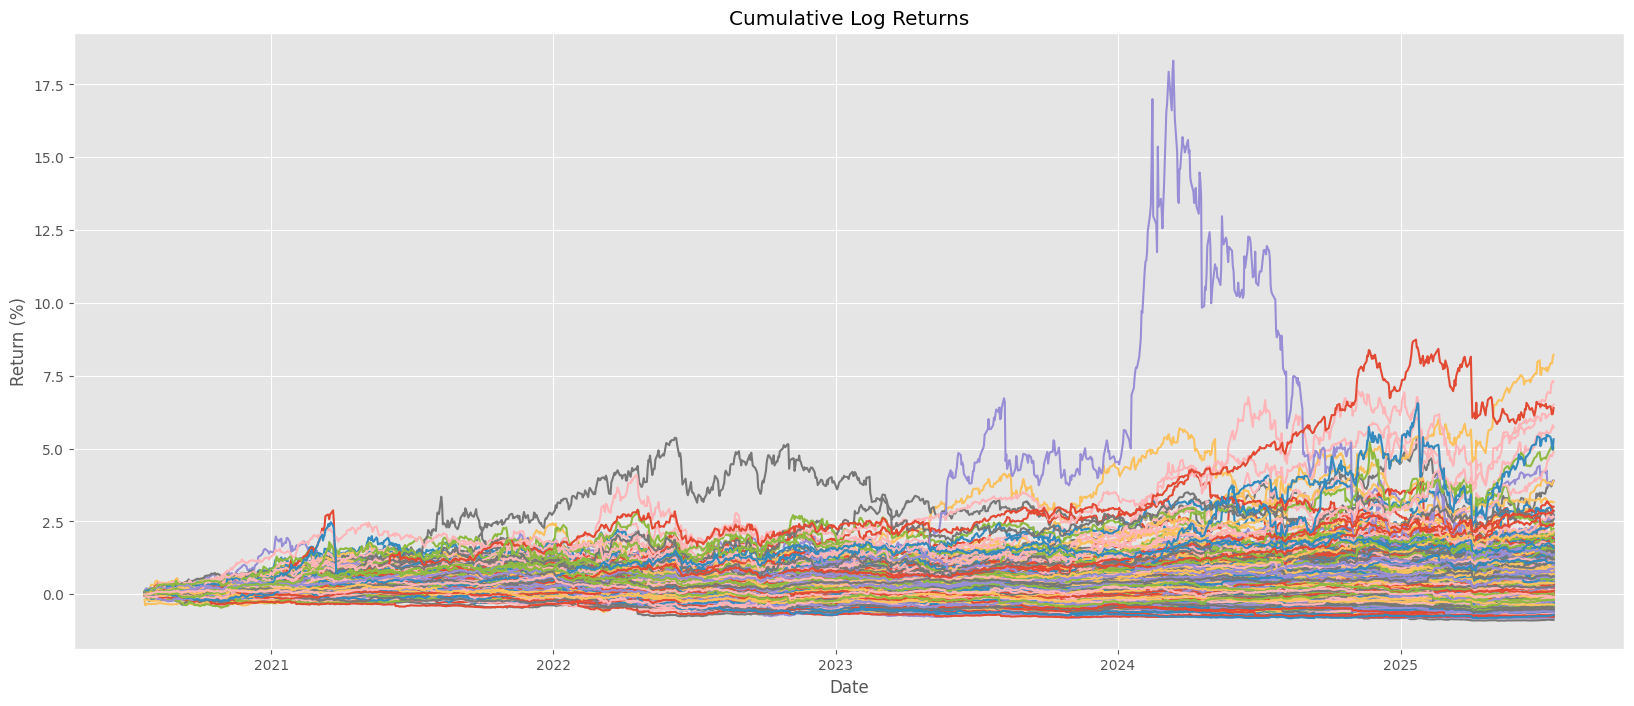

In [339]:
# Calculate the daily returns (log)
returns = np.log(data / data.shift(1)).dropna()

cumulative_returns = (1 + returns).cumprod() - 1

plt.figure(figsize=(20, 8))
plt.plot(cumulative_returns)
plt.title("Cumulative Log Returns")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.show()

### Part 1: Optimally Risky Portfolios
Mean-variance optimization was an idea developed by Harry Markowitz to construct an optimally risky portfolio. Assuming a stock's return distribution is normal (questionable), it can be completely be characterized by its mean (expectation) and standard deviation. The objective of the procedure is to find the portfolio (P), such that is has the highest Sharpe ratio $S_P$.<br>
$S_P=\frac{E[r_P]-r_f}{\sigma_P}$ where,
<br>
<br>
$r_f$ = risk-free rate
<br>
$E[r_P]=\sum_{i=1}^{N} w_i*E[r_i]$
<br>
$\sigma_P^2=w*\Sigma*w^T$ where,
<br>
w - list of portfolio weights<br>
$\Sigma$ - covariance matrix of component returns
<br>
<br>
The objective for the constrained maximization is then given by,
<br>
$\max_{w} S_P$
<br>
<br>
The constraint and bounds of the optimization can be changed depending on the portfolio's objectives. Some examples of bounds and constraints are:<br>
$w_i\exists (0,1)$ for long-only bounds<br>
$w_i\exists (-1,1)$ for long-short bounds<br>
$\sum_{i=1}^{N}w_i = 1$ for non-leveraged long only portfolios<br>
$\sum_{i=1}^{N}w_i = 1.5$ for leveraged long only portfolios<br>
$\sum_{i=1}^{N}|w_i| = 1$ for non-leveraged long-short portfolios<br>
$\sum_{i=1}^{N}|w_i| = 1.5$ for leveraged long-short portfolios
<br>
<br>
The following code creates four portfolios with different optimization bounds and constraints.
* Portfolio 1: Long only, non-leveraged
* Portfolio 2: Long only, leveraged
* Portfolio 3: Long-Short

In [340]:
def portfolio_er(weights, er):
    """
    * Computes the expected return of the portfolio given the
    * component weights and individual expected returns.
    *
    * weights: list of component weights
    * er: list of expected returns
    * NOTE: index of weights and er must match
    *
    * return: portfolio expected return (E(p))
    """

    return np.dot(np.array(weights), np.array(er))

def portfolio_var(weights, cov_matrix):
    """
    * Computes the variance of the portfolio given the component
    * weights and the covariance matrix.
    *
    * weights: list of component weights
    * cov_matrix: matrix of covariances between the individual
    *             components; diagonals are variances
    * NOTE: index of weights and cov_matrix must match
    *
    * return: portfolio variance (Var(p))
    """

    return np.dot(weights, np.dot(cov_matrix, weights.T))

In [341]:
# Objective Function
def negative_sharpe_ratio(w, rets, cov_matrix, rate=0.025):
    """
    * Computes the negative Sharpe ratio for a portfolio of components.
    * The negative factor in this calculation is used to convert the
    * minimzation problem into an maximization problem.
    *
    * rets: list of component expected returns
    * cov_matrix: matrix of covariances between the individual
    *             components; diagonals are variances
    * w: list of component weights
    * rate: interest rate to calculate excess return
    * NOTE: index of each input parameter must be equivalent
    *
    * return: negative portfolio Sharpe ratio
    """

    return -(portfolio_er(w, rets) - rate) / np.sqrt(portfolio_var(w, cov_matrix))

In [342]:
def optimization_results(res, tickers, rate):
    # Extract the optimized weights
    optimized_weights = res.x
    portfolio_weights = dict(zip(tickers, optimized_weights))

    # Filter only stocks with a +/- 1% or larger portfolio weight
    filtered_weights = {k: v for k, v in portfolio_weights.items() if abs(v) >= 0.01}

    gross_leverage = sum([abs(w) for w in optimized_weights])

    # Print the results (expected portfolio performance)
    print(f'Optimized Weights(filtered): {filtered_weights}')
    print(f'Portfolio Size(filtered): {len(filtered_weights)}')
    print(f'Portfolio Expected Return: {portfolio_er(res.x, expected_returns)}')
    print(f'Portfolio Standard Deviation: {np.sqrt(portfolio_var(res.x, covariance_matrix))}')
    print(f'Portfolio Sharpe Ratio: {-negative_sharpe_ratio(res.x, expected_returns, covariance_matrix, rate=rate)}')
    print(f'Gross Portfolio Leverage: {round(gross_leverage, 5)}')

    # Plot the results
    plt.figure(figsize=(20, 8))
    plt.bar(filtered_weights.keys(), filtered_weights.values())
    plt.title("Portfolio Weights (Filtered)")
    plt.xlabel("Ticker")
    plt.ylabel("Weight")
    plt.show()

True
Optimization terminated successfully
Optimized Weights(filtered): {'AVGO': 0.05149506686055981, 'AXON': 0.036736888093531796, 'CBOE': 0.09645545232789798, 'HWM': 0.10063229158119116, 'KR': 0.05708429896252171, 'LLY': 0.08908033796116008, 'MCK': 0.21626082125095245, 'NVDA': 0.020588449720039842, 'ORLY': 0.017784418111059033, 'PGR': 0.010199275758609436, 'PM': 0.12483811274612651, 'PWR': 0.0680065455418823, 'TPR': 0.0382707252803751, 'TRGP': 0.04692699734692911, 'VST': 0.016923147185684315}
Portfolio Size(filtered): 15
Portfolio Expected Return: 0.34597644521212123
Portfolio Standard Deviation: 0.15695134986524953
Portfolio Sharpe Ratio: 1.9303844501639613
Gross Portfolio Leverage: 1.0


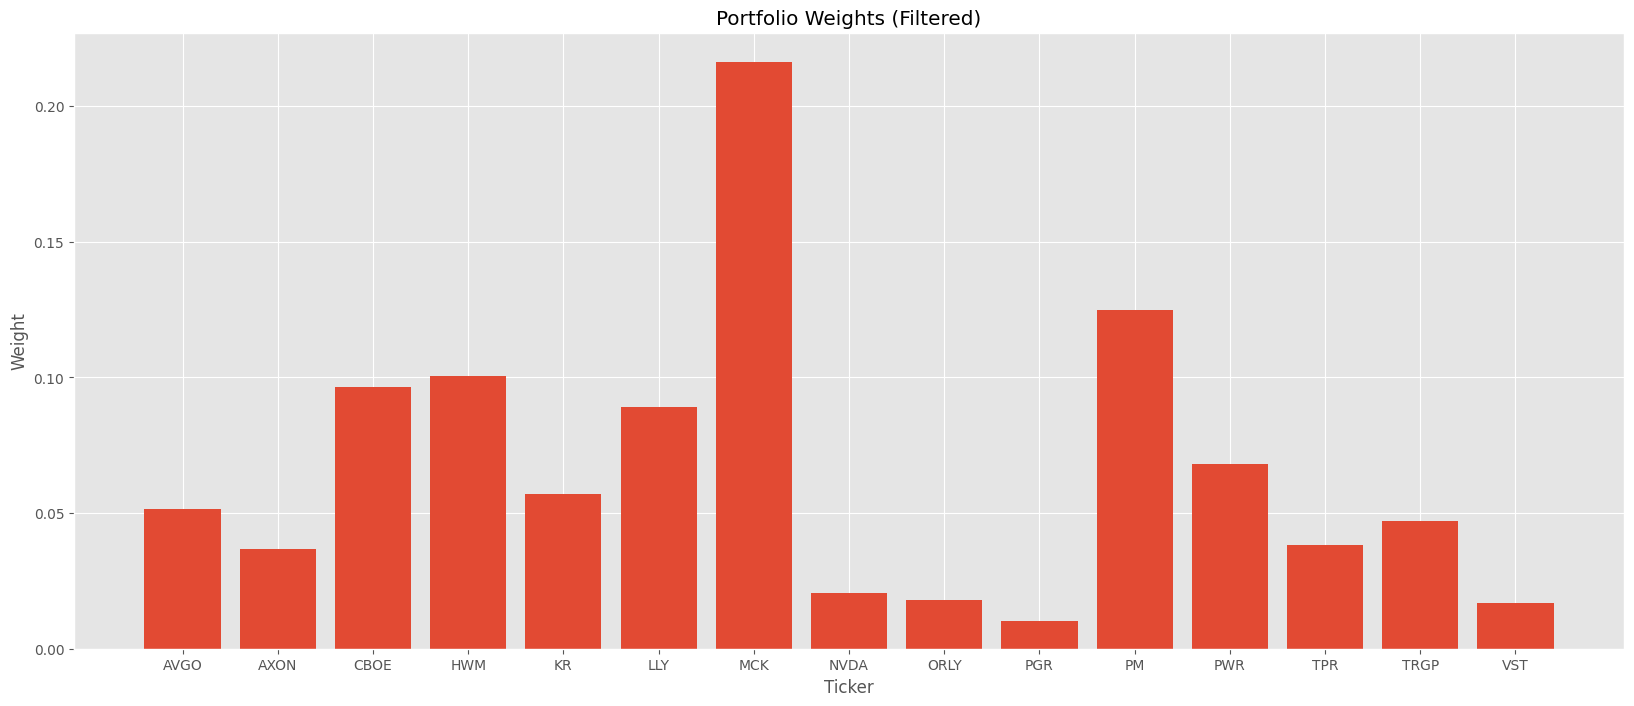

In [343]:
# Mean-Variance Optimization
method = "SLSQP"
weights = [1 / len(returns.columns)] * len(returns.columns)

# Compute the component covariance matrix and expected returns
covariance_matrix = returns.cov() * 252
expected_returns = returns.mean() * 252

# Allows for long only positions
# Constraining the net portfolio exposure to 1 (non-leveraged)
constraint = {
    'type' : 'eq',                  # Equivalency constraint
    'fun' : lambda w: 1 - np.sum(w) # Sum of all weights equals 1
}
bounds = [(0, 1)] * len(weights)    # Each weight is between 0 and 1

# Maximization
portfolio1_res = minimize(negative_sharpe_ratio,
                 weights,
                 args = (expected_returns, covariance_matrix, risk_free),
                 method = method,
                 bounds = bounds,
                 constraints = [constraint])

print(portfolio1_res.success)
print(portfolio1_res.message)

# Print and plot the optimization results
optimization_results(portfolio1_res, returns.columns, risk_free)

True
Optimization terminated successfully
Optimized Weights(filtered): {'AVGO': 0.07777475842652978, 'AXON': 0.055150740143015776, 'CBOE': 0.1446392552385683, 'HWM': 0.15073940485475032, 'KR': 0.08586973305421279, 'LLY': 0.1336679974733962, 'MCK': 0.32437310899420096, 'NVDA': 0.031018970704591146, 'ORLY': 0.02604813323787637, 'PGR': 0.015165992814478448, 'PM': 0.18751306851115793, 'PWR': 0.10182622061788794, 'SMCI': 0.012913768219265806, 'TPR': 0.05725677603623752, 'TRGP': 0.07077580347368961, 'VST': 0.025266268200093405}
Portfolio Size(filtered): 16
Portfolio Expected Return: 0.51900558530522
Portfolio Standard Deviation: 0.23544836485621398
Portfolio Sharpe Ratio: 1.9282596656913578
Gross Portfolio Leverage: 1.5


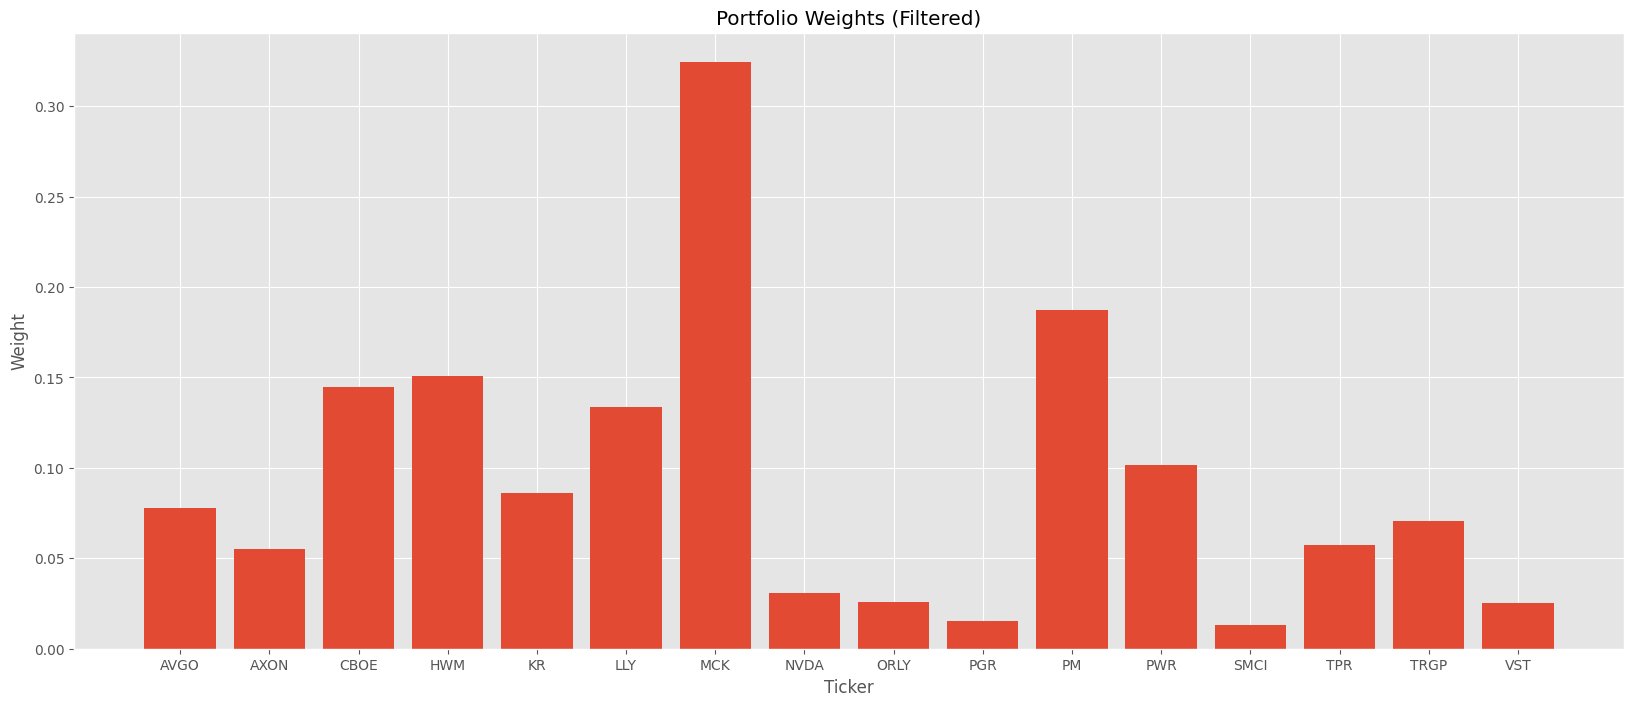

In [344]:
# Mean-Variance Optimization
method = "SLSQP"
weights = [1 / len(returns.columns)] * len(returns.columns)

# Allows for long only positions
# Allowing for 1.5x gross leverage
constraint = {
    'type' : 'eq',                    # Equivalency constraint
    'fun' : lambda w: 1.5 - np.sum(w) # Sum of all weights equals 1
}
bounds = [(0, 1)] * len(weights)    # Each weight is between 0 and 1

# Maximization
portfolio2_res = minimize(negative_sharpe_ratio,
                 weights,
                 args = (expected_returns, covariance_matrix, borrow_rate),
                 method = method,
                 bounds = bounds,
                 constraints = [constraint])

print(portfolio2_res.success)
print(portfolio2_res.message)

# Print and plot the optimization results
optimization_results(portfolio2_res, returns.columns, borrow_rate)

True
Optimization terminated successfully
Optimized Weights(filtered): {'ABBV': 0.011362693977484642, 'AVGO': 0.06983195959470538, 'AXON': 0.05438082997758912, 'CBOE': 0.11870116466389391, 'CZR': -0.055527432726784974, 'EL': -0.02297439195393176, 'GPN': -0.03216291286067244, 'HWM': 0.09063662295117701, 'INTC': -0.04468665414595407, 'K': 0.037611554677110956, 'KR': 0.06567305557286643, 'LLY': 0.0679057206288899, 'MCK': 0.165952705258051, 'MTCH': -0.02791280218219865, 'NVDA': 0.03871338222341142, 'ORLY': 0.054017661223349535, 'PANW': 0.011558276894420932, 'PGR': 0.01754505368175259, 'PM': 0.1433477949009359, 'PWR': 0.05446814990169174, 'RSG': 0.012969559755916864, 'SMCI': 0.011172996486184038, 'SO': 0.05070885812561619, 'SW': 0.012479792114132577, 'TFX': -0.04850633202367584, 'TPR': 0.07923611372889451, 'TRGP': 0.04880897715695028, 'WELL': 0.026020029722219392}
Portfolio Size(filtered): 28
Portfolio Expected Return: 0.43924331647700127
Portfolio Standard Deviation: 0.14558107360195333
Po

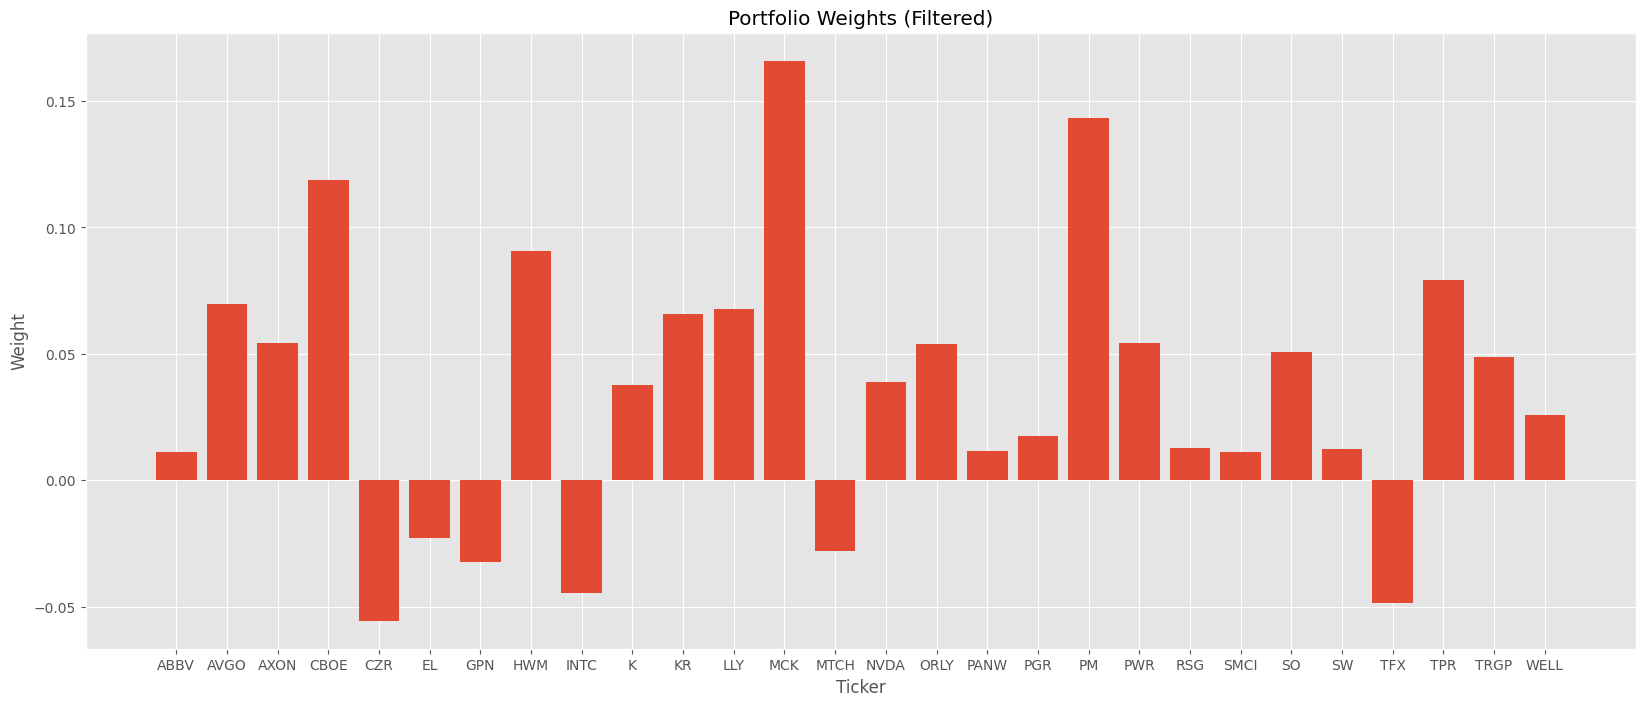

In [345]:
# Mean-Variance Optimization
method = "SLSQP"
weights = [1 / len(returns.columns)] * len(returns.columns)

# Allows for long and short positions
constraints = [
    {'type' : 'eq', 'fun' : lambda w: np.sum(w) - 1},
    {'type' : 'ineq', 'fun' : lambda w: 1.5 - np.sum(np.abs(w))}
]

bounds = [(-1, 1)] * len(weights) # Each weight is between -1 and 1

# Maximization
portfolio3_res = minimize(negative_sharpe_ratio,
                 weights,
                 args = (expected_returns, covariance_matrix, borrow_rate),
                 method = method,
                 bounds = bounds,
                 constraints = constraints,
                 options = {'maxiter' : 10_000})

# Print optimization results
print(portfolio3_res.success)
print(portfolio3_res.message)

# Print and plot the optimization results
optimization_results(portfolio3_res, returns.columns, borrow_rate)

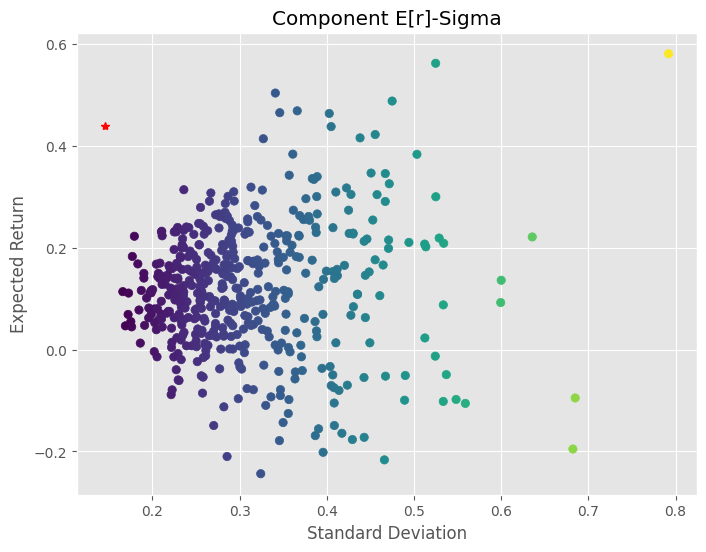

In [346]:
# Plot the expected return-standard deviation space for all individual components
# and the portfolio with the highest Sharpe ratio (portfolio 3)
x = returns.std() * np.sqrt(252)
y = expected_returns

p_er = portfolio_er(portfolio3_res.x, expected_returns)
p_sd = np.sqrt(portfolio_var(portfolio3_res.x, covariance_matrix))

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=x, cmap='viridis')
plt.plot(p_sd, p_er, marker='*', color='red')
plt.title("Component E[r]-Sigma")
plt.xlabel("Standard Deviation")
plt.ylabel("Expected Return")
plt.show()

#### Part 1: Discussion
Observed above, the non-leveraged long only and leveraged long-only portfolios have almost identical Sharpe ratios. The leveraged portfolio has a higher expected return and standard deviation, but incurs a rate above risk free to reflect borrowing costs. Because they are both using long-only mean-variance optimization, their portfolio weights are almost identical. The long-short portfolio has an improved Sharpe ratio of 2.57, resulting from a higher expected return and lower standard deviation. To test the optimization strategies through time, Part 2 of the notebook backtests the optimization procedure over different lookback and holding periods.